In [2]:
import cfgrib
import pandas as pd
import polars as pl
import xarray as xr

from compstat_research.config import EXTERNAL_DATA_DIR, PROCESSED_DATA_DIR

2025-02-16 19:16:22.706 | INFO     | compstat_research.config:<module>:11 - PROJ_ROOT path is: D:\Documents\3 Production Save Files\1 Cloned repositories\compstat-research


In [2]:
data_path = EXTERNAL_DATA_DIR / "cds" / "ERA5-post-processed-daily-statistics"

data = xr.open_dataset(data_path / "2024.nc")
data

<xarray.Dataset> Size: 5MB
Dimensions:     (valid_time: 366, latitude: 61, longitude: 61)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 488B 20.0 19.75 19.5 19.25 ... 5.5 5.25 5.0
  * longitude   (longitude) float64 488B 115.0 115.2 115.5 ... 129.5 129.8 130.0
  * valid_time  (valid_time) datetime64[ns] 3kB 2024-01-01 ... 2024-12-31
Data variables:
    t2m         (valid_time, latitude, longitude) float32 5MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-05T11:13 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
test_data = data.to_dataframe().reset_index()
test_data.describe()

,valid_time,latitude,longitude,t2m,number
count,1361886,1.361886e+06,1.361886e+06,1.361886e+06,1361886.0
mean,2024-07-01 11:59:59.999999744,1.250000e+01,1.225000e+02,3.007350e+02,0.0
min,2024-01-01 00:00:00,5.000000e+00,1.150000e+02,2.875187e+02,0.0
25%,2024-04-01 00:00:00,8.750000e+00,1.187500e+02,3.001617e+02,0.0
50%,2024-07-01 12:00:00,1.250000e+01,1.225000e+02,3.009370e+02,0.0
75%,2024-10-01 00:00:00,1.625000e+01,1.262500e+02,3.016189e+02,0.0
max,2024-12-31 00:00:00,2.000000e+01,1.300000e+02,3.069055e+02,0.0
std,NaN,4.401706e+00,4.401706e+00,1.392313e+00,0.0


<Axes: xlabel='valid_time'>

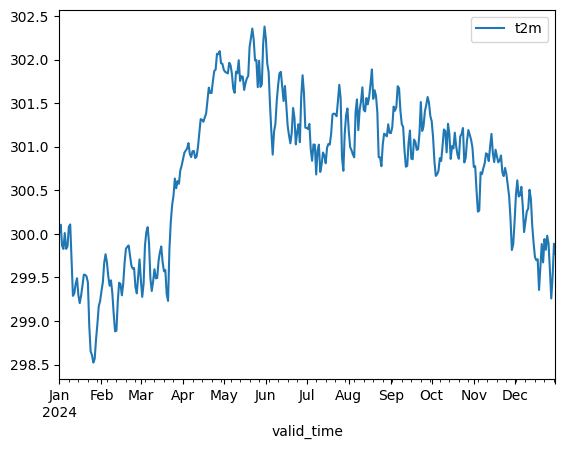

In [9]:
test_data.groupby("valid_time").agg({"t2m": "mean"}).plot()

In [ ]:
# query by year

import polars as pl
import duckdb

from compstat_research.config import EXTERNAL_DATA_DIR, PROCESSED_DATA_DIR

data_path = PROCESSED_DATA_DIR / "cds" / "era5" / "2m-temperature" / "global"

conn = duckdb.connect(data_path / "era5-2m-temperature-global.duckdb", read_only=True)

data = conn.sql("""
SELECT 
    DATE_PART('year', valid_time) as temp_year,
    AVG(t2m) as avg_temp
FROM 
    temperature 
GROUP BY 
    temp_year
ORDER BY
    temp_year
""").pl()

data.write_parquet(data_path / "era5-2m-temperature-global-yearly-avg.parquet")

2025-02-16 23:01:32.570 | INFO     | compstat_research.config:<module>:11 - PROJ_ROOT path is: D:\Documents\3 Production Save Files\1 Cloned repositories\compstat-research


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [2]:
# query by daily

import duckdb

from compstat_research.config import PROCESSED_DATA_DIR

data_path = PROCESSED_DATA_DIR / "cds" / "era5" / "2m-temperature" / "global"

conn = duckdb.connect(data_path / "era5-2m-temperature-global.duckdb", read_only=True)

data = conn.sql("""
SELECT 
    DATE_PART('year', valid_time) as temp_year,
    DATE_PART('month', valid_time) as temp_month,
    DATE_PART('day', valid_time) as temp_day,
    AVG(t2m) as avg_temp
FROM 
    temperature 
GROUP BY 
    temp_year,
    temp_month,
    temp_day
ORDER BY
    temp_year,
    temp_month,
    temp_day
""").pl()

data.write_parquet(data_path / "era5-2m-temperature-global-daily-avg.parquet")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2025-02-17 01:45:30.181 | INFO     | compstat_research.config:<module>:11 - PROJ_ROOT path is: D:\Documents\3 Production Save Files\1 Cloned repositories\compstat-research


<Axes: xlabel='temp_year', ylabel='avg_temp'>

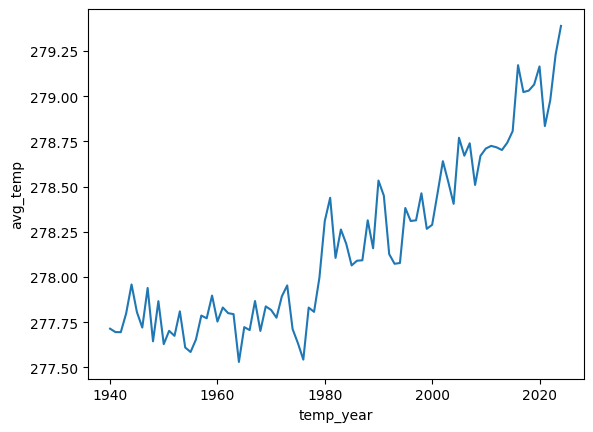

In [1]:
import seaborn as sns
import polars as pl

from compstat_research.config import EXTERNAL_DATA_DIR, PROCESSED_DATA_DIR

data_path = PROCESSED_DATA_DIR / "cds" / "era5" / "2m-temperature" / "global"

temp_yearly = pl.read_parquet(data_path / "era5-2m-temperature-global-yearly-avg.parquet")

sns.lineplot(data=temp_yearly, x="temp_year", y="avg_temp")

In [45]:
import seaborn as sns
import polars as pl

from compstat_research.config import EXTERNAL_DATA_DIR, PROCESSED_DATA_DIR

data_path = PROCESSED_DATA_DIR / "cds" / "era5" / "2m-temperature" / "global"

temp_daily = pl.read_parquet(
    source=data_path / "era5-2m-temperature-global-daily-avg.parquet",
    low_memory=True,
    use_pyarrow=True,
    memory_map=True,
    )

In [46]:
temp_daily

temp_year,temp_month,temp_day,avg_temp
i64,i64,i64,f64
1940,1,2,276.007051
1940,1,3,275.975732
1940,1,4,275.934177
1940,1,5,275.893011
1940,1,6,275.7141
…,…,…,…
2024,12,27,278.369356
2024,12,28,278.28687
2024,12,29,278.242523


In [47]:
temp_daily = temp_daily.with_columns(
    pl.date(
        pl.col("temp_year"),
        pl.col("temp_month"),
        pl.col("temp_day")
    ).alias("temp_date")
)
temp_daily.head()

temp_year,temp_month,temp_day,avg_temp,temp_date
i64,i64,i64,f64,date
1940,1,2,276.007051,1940-01-02
1940,1,3,275.975732,1940-01-03
1940,1,4,275.934177,1940-01-04
1940,1,5,275.893011,1940-01-05
1940,1,6,275.7141,1940-01-06


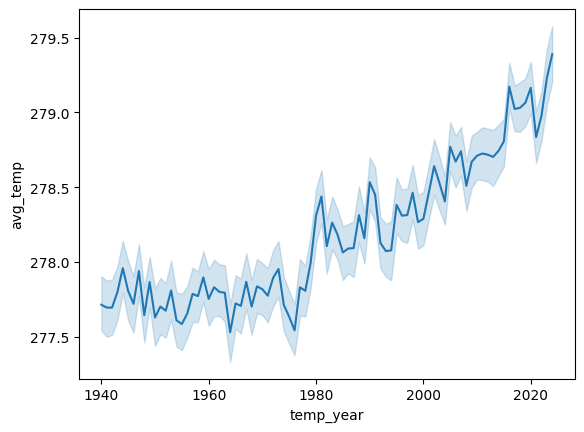

In [48]:
ax = sns.lineplot(
    data=temp_daily, 
    x='temp_year', 
    y='avg_temp',
    errorbar=("ci", 95),
    )

In [49]:
temp_monthly = temp_daily.group_by(["temp_year", "temp_month"]).agg(
    avg_temp_monthly=pl.col("avg_temp").mean()
)
temp_monthly.head()

temp_year,temp_month,avg_temp_monthly
i64,i64,f64
1961,7,280.421928
2006,10,278.620145
2005,4,277.612394
1997,8,280.432852
1987,4,277.182662


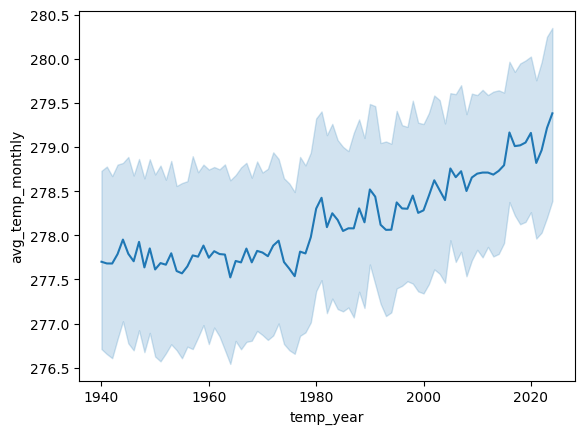

In [50]:
ax = sns.lineplot(
    data=temp_monthly, 
    x='temp_year', 
    y='avg_temp_monthly',
    )